In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'

In [3]:
import gc
import os
import sys

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from copy import deepcopy
from random import shuffle
from scipy.stats import spearmanr

from access_biology_data import lincs, properties
from access_science_shared import standardizer

sys.path.append('./../src/')
from aging_tools import inout, export

from access_biology_data import annotation
from access_biology_data import meta

In [4]:
outfolder = '211007_gtex_with_self_controls_all_cds'

# Note

#here the "no brain" is all samples, including brain

In [5]:
save_images = True

In [6]:
ref_genes = standardizer.reference_genes(9606, 'orp')

/Users/tstoeger/opt/miniconda3/envs/aging/lib/python3.7/site-packages/fastparquet/dataframe.py:5: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import CategoricalIndex, RangeIndex, Index, MultiIndex


In [7]:
import glob

In [8]:
p =export.get_material_path(
    '211007_cache_gtex_self_controls_cds/stats_on_imbalance_self_controls.xlsx')

d_self = pd.read_excel(p)

In [9]:
p =export.get_material_path(
    '211007_chache_tstoeger_190427_gtex_with_tilt_cds/stats_on_imbalance.xlsx')

In [10]:
d = pd.read_excel(p)

In [11]:
d.head()

,condition,tilt,pval,tilt_orp,pval_orp,gender,tissue,younger,older
0,females_Adipose_Subcutaneous_3_vs_2,0.213022,6.813422e-177,0.215273,7.323372e-180,female,Adipose - Subcutaneous,2,3
1,females_Adipose_Subcutaneous_4_vs_2,0.149815,1.370616e-87,0.150938,1.771133e-88,female,Adipose - Subcutaneous,2,4
2,females_Adipose_Subcutaneous_4_vs_3,-0.116254,2.996162e-53,-0.117635,3.073236e-54,female,Adipose - Subcutaneous,3,4
3,females_Adipose_Subcutaneous_5_vs_2,0.106044,1.291552e-44,0.107374,1.710456e-45,female,Adipose - Subcutaneous,2,5
4,females_Adipose_Subcutaneous_5_vs_3,-0.140102,7.134241e-77,-0.141201,1.045836e-77,female,Adipose - Subcutaneous,3,5


In [12]:
d = d.rename(columns={'tilt': 'rho', 'tissue': 'region'})

In [13]:
d['gender'] = d['gender'] + 's'

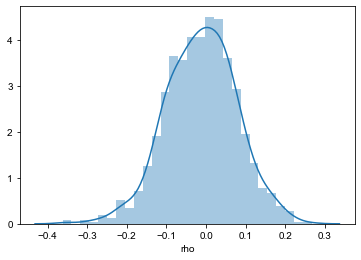

In [14]:
sns.distplot(d['rho'])

In [15]:
agg = []

for gender in ['males', 'females']:

    s = d[(d['gender']==gender)].copy()

    f = (s['younger'].isin([2, 3]) & s['older'].isin([4, 5]))
    s.loc[f, 'cat'] = '20/30 to 40/50'

    f = (s['younger'].isin([4, 5]) & s['older'].isin([6, 7]))
    s.loc[f, 'cat'] = '40/50 to 60/70'

    f = (s['younger'].isin([2, 3]) & s['older'].isin([6, 7]))
    s.loc[f, 'cat'] = '20/30 to 60/70'

    s = s.dropna(subset=['cat'])

    s = s[['pval', 'region', 'cat', 'rho']].groupby(['region', 'cat']).agg(np.median)

    s = s.reset_index()
    comparisons_per_tissue = s['region'].value_counts()
    
    # only consider, if all thre age comparisons are there
    s = s[s['region'].isin(comparisons_per_tissue[comparisons_per_tissue==3].index)]

    order = s[['region', 'rho']].groupby('region').agg(np.median).sort_values('rho')

    hue_order=['20/30 to 40/50','20/30 to 60/70', '40/50 to 60/70', ]

#     plt.figure(figsize=(5, 10))
#     sns.swarmplot(x='rho', y='region',data=s, hue='cat',
#                 order=order[order.index.str.startswith('Brain')].index,
#                 hue_order=hue_order
#                  )
#     plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#     if save_images:
#         export.export_image(
#             '{}/{}_brain.pdf'.format(
#                 outfolder,
#                 gender))

#     plt.figure(figsize=(5, 10))
#     sns.swarmplot(x='rho', y='region',data=s, hue='cat',
#                 order=order[~order.index.str.startswith('Brain')].index,
#                 hue_order=hue_order
#                  )
#     plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#     if save_images:
#         export.export_image(
#             '{}/{}_non_brain.pdf'.format(
#                 outfolder,
#                 gender))

#     plt.figure(figsize=(5, 10))
#     sns.swarmplot(x='rho', y='region',data=s, hue='cat',
#                 order=order.index,
#                 hue_order=hue_order
#                  )
#     plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#     if save_images:
#         export.export_image(
#             '{}/{}_all.pdf'.format(
#                 outfolder,
#                 gender))
        
#     if save_images:
#         export.export_full_frame(
#             '{}/{}_all.xlsx'.format(
#                     outfolder,
#                     gender), 
#             s)
        
#         export.export_full_frame(
#             '{}/{}_young_to_old.xlsx'.format(
#                     outfolder,
#                     gender), 
#             s[s['cat']=='20/30 to 60/70'])  
        
    s.loc[:, 'gender'] = gender
    agg.append(s)

In [16]:
d['younger'].value_counts()

2    375
3    285
4    247
5    158
6     70
Name: younger, dtype: int64

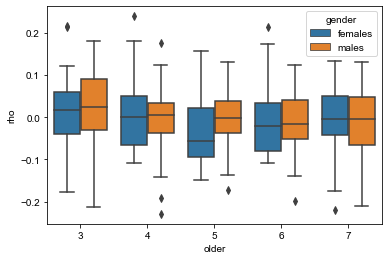

In [17]:
sns.boxplot(
    x='older',
    y='rho',
    data=d[d['younger']==2],
    hue='gender'

)

In [18]:
e = pd.concat(agg)

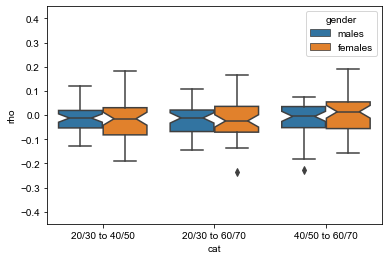

In [19]:
sns.boxplot(x='cat', y='rho', data=e, hue='gender', notch=True)
plt.ylim(-0.45, 0.45)

if save_images:
    export.export_image(
        '{}/notched_box_by_third.pdf'.format(
            outfolder))

In [20]:
a = e.copy()
b = e[e['region'].str.startswith('Brain -')].copy()

a.loc[:, 'is_brain'] = False
b.loc[:, 'is_brain'] = True

e = pd.concat([a, b])

e['is_brain'] = e['is_brain'].astype(float)

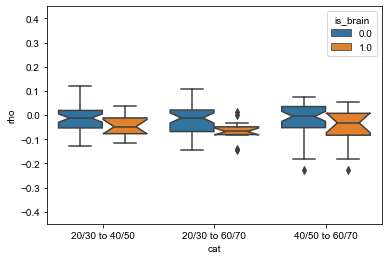

In [21]:
sns.boxplot(x='cat', y='rho', data=e[e['gender']=='males'], hue='is_brain', notch=True)

plt.ylim(-0.45, 0.45)



if save_images:
    export.export_image(
        '{}/notched_box_by_male_brain.pdf'.format(
            outfolder))

In [22]:
e.head()

,region,cat,pval,rho,gender,is_brain
0,Adipose - Subcutaneous,20/30 to 40/50,1.302583e-10,-0.003812,males,0.0
1,Adipose - Subcutaneous,20/30 to 60/70,3.871957e-04,0.019523,males,0.0
2,Adipose - Subcutaneous,40/50 to 60/70,1.646914e-10,0.008341,males,0.0
3,Adipose - Visceral (Omentum),20/30 to 40/50,7.514724e-02,0.002517,males,0.0
4,Adipose - Visceral (Omentum),20/30 to 60/70,8.715350e-03,0.020501,males,0.0


In [23]:
d_self['tissue'].isin(e['region']).mean()

0.9551515151515152

In [24]:
e_self = d_self.copy()

In [25]:
a = e_self.copy()
b = e_self[e_self['tissue'].str.startswith('Brain -')].copy()

a.loc[:, 'is_brain'] = False
b.loc[:, 'is_brain'] = True

In [26]:
e_self = pd.concat([a, b])

In [27]:
# e['is_brain'] = e['is_brain'].astype(float)

In [28]:
e_self['cat'] = e_self['decade'].apply(lambda x: 'self_{}'.format(int(np.floor(x/2)*2)))

In [29]:
e_self['gender'] = e_self['gender'] + 's'

In [30]:
# e_self['is_brain'] = e_self['tissue'].str.contains('Brain')

In [31]:
e_self.head()

,tilt,pval,filename,tissue,decade,animals,gender,is_brain,cat
0,0.002441,7.704424e-01,Cells - EBV-transformed lymphocytes_pfu_0_age_...,Cells - EBV-transformed lymphocytes,2,7325-7328-7333,males,False,self_2
1,-0.038115,2.963866e-06,Brain - Frontal Cortex (BA9)_pfu_0_age_5_first...,Brain - Frontal Cortex (BA9),5,2982-3009-3016,males,False,self_4
2,-0.190036,2.969331e-121,Lung_pfu_0_age_2_first_7249-7251-7252_DE.csv,Lung,2,7249-7251-7252,males,False,self_2
3,-0.042634,8.058607e-08,Liver_pfu_0_age_5_first_3480-3484-3491_DE.csv,Liver,5,3480-3484-3491,males,False,self_4
4,-0.130273,2.489861e-60,Prostate_pfu_0_age_6_first_1237-1295-1302_DE.csv,Prostate,6,1237-1295-1302,males,False,self_6


In [32]:
e_self = e_self.rename(columns={'tissue': 'region', 'tilt': 'rho'})

In [33]:
e_self = pd.merge(e_self, e[['gender', 'region']].drop_duplicates())

In [34]:
e.head()

,region,cat,pval,rho,gender,is_brain
0,Adipose - Subcutaneous,20/30 to 40/50,1.302583e-10,-0.003812,males,0.0
1,Adipose - Subcutaneous,20/30 to 60/70,3.871957e-04,0.019523,males,0.0
2,Adipose - Subcutaneous,40/50 to 60/70,1.646914e-10,0.008341,males,0.0
3,Adipose - Visceral (Omentum),20/30 to 40/50,7.514724e-02,0.002517,males,0.0
4,Adipose - Visceral (Omentum),20/30 to 60/70,8.715350e-03,0.020501,males,0.0


In [35]:
e_median = e_self[['region', 'cat', 'pval', 'rho', 'gender', 'is_brain']].groupby(
    ['region', 'cat']
).median().reset_index()

In [36]:
e_median['cat'] = e_median['cat'] + '_median'

In [37]:
e_self_mask = e_self.copy()
e_self_mask['is_brain'] = False

In [38]:
e_median_mask = e_median.copy()
e_median_mask['is_brain'] = False

In [39]:
# me = pd.concat([
#     e,
#     e_self[['region', 'cat', 'pval', 'rho', 'gender', 'is_brain']],
#     e_median
# ]

# )

In [40]:
me = pd.concat([
    e,
    e_self_mask[['region', 'cat', 'pval', 'rho', 'gender', 'is_brain']],
    e_median_mask
]

)

In [41]:
e[
    (e['is_brain']==False) &
    (e['cat']=='20/30 to 40/50')
].shape

(86, 6)

In [42]:
e[
    (e['is_brain']==False) &
    (e['cat']=='20/30 to 40/50') &
    (e['region'].str.startswith('Brain'))
].shape

(24, 6)

In [43]:
e[
    (e['is_brain']==False) &
    (e['cat']=='20/30 to 60/70')
].shape

(86, 6)

In [44]:
e[
    (e['is_brain']==False) &
    (e['cat']=='20/30 to 60/70') &
    (e['region'].str.startswith('Brain'))
].shape

(24, 6)

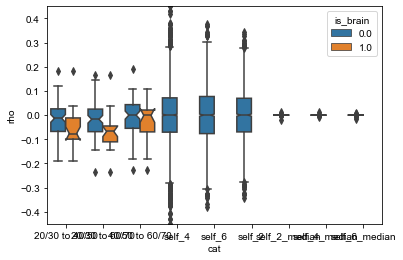

In [45]:
sns.boxplot(x='cat', y='rho', data=me, hue='is_brain', notch=True)
plt.ylim(-0.45, 0.45)

if save_images:
    export.export_image(
        '{}/notched_box_by_third_with_permutations.pdf'.format(
            outfolder))

In [46]:
from scipy.stats import mannwhitneyu

In [47]:
a = me[
    (me['cat']=='20/30 to 40/50') &
    (me['is_brain']==False)
]['rho']

b = me[
    (me['cat']=='self_2_median') &
    (me['is_brain']==False)
]['rho']

mannwhitneyu(a, b, alternative='two-sided')

MannwhitneyuResult(statistic=1296.0, pvalue=0.06736512571430602)

In [48]:
a = me[
    (me['cat']=='20/30 to 60/70') &
    (me['is_brain']==False)
]['rho']

b = me[
    (me['cat']=='self_2_median') &
    (me['is_brain']==False)
]['rho']

mannwhitneyu(a, b, alternative='two-sided')

MannwhitneyuResult(statistic=1359.0, pvalue=0.13681052578830555)

In [49]:
a = me[
    (me['cat']=='20/30 to 40/50') &
    (me['is_brain']==True)
]['rho']

b = me[
    (me['cat']=='self_2_median') &
    (me['is_brain']==False)
]['rho']

mannwhitneyu(a, b, alternative='two-sided')

MannwhitneyuResult(statistic=192.0, pvalue=0.00014006245465182838)

In [50]:
a = me[
    (me['cat']=='20/30 to 60/70') &
    (me['is_brain']==True)
]['rho']

b = me[
    (me['cat']=='self_2_median') &
    (me['is_brain']==False)
]['rho']

mannwhitneyu(a, b, alternative='two-sided')

MannwhitneyuResult(statistic=142.0, pvalue=5.8802600729410615e-06)

In [51]:
a = me[
    (me['cat']=='20/30 to 40/50') &
    (me['is_brain']==False)
]['rho']

b = me[
    (me['cat']=='self_2') &
    (me['is_brain']==False)
]['rho']

mannwhitneyu(a, b, alternative='two-sided')    #########P = 0.003

MannwhitneyuResult(statistic=82146.0, pvalue=0.039263038617119835)

In [52]:
# a = me[
#     (me['cat']=='20/30 to 40/50') &
#     (me['is_brain']==True)
# ]['rho']

# b = me[
#     (me['cat']=='self_2') &
#     (me['is_brain']==True)
# ]['rho']

# mannwhitneyu(a, b, alternative='two-sided')

In [53]:
a = me[
    (me['cat']=='20/30 to 60/70') &
    (me['is_brain']==False)
]['rho']

b = me[
    (me['cat']=='self_2') &
    (me['is_brain']==False)
]['rho']

mannwhitneyu(a, b, alternative='two-sided')

MannwhitneyuResult(statistic=80863.0, pvalue=0.022889714678715)

In [54]:
a = me[
    (me['cat']=='20/30 to 40/50') &
    (me['is_brain']==True)
]['rho']

b = me[
    (me['cat']=='self_2') &
    (me['is_brain']==False)
]['rho']

mannwhitneyu(a, b, alternative='two-sided')

MannwhitneyuResult(statistic=16557.0, pvalue=0.0016846086738763657)

In [55]:
a = me[
    (me['cat']=='20/30 to 60/70') &
    (me['is_brain']==True)
]['rho']

b = me[
    (me['cat']=='self_2') &
    (me['is_brain']==False)
]['rho']

mannwhitneyu(a, b, alternative='two-sided')

MannwhitneyuResult(statistic=14734.0, pvalue=0.00019608625041982907)

In [56]:
e_self['cat'].value_counts()

self_4    4084
self_6    2932
self_2    2198
Name: cat, dtype: int64

In [57]:
a = me[
    (me['cat']=='20/30 to 60/70') &
    (me['is_brain']==False)
]['rho']

b = me[
    (me['cat']=='self_2') &
    (me['is_brain']==False)
]['rho']

mannwhitneyu(a, b, alternative='two-sided')

MannwhitneyuResult(statistic=80863.0, pvalue=0.022889714678715)

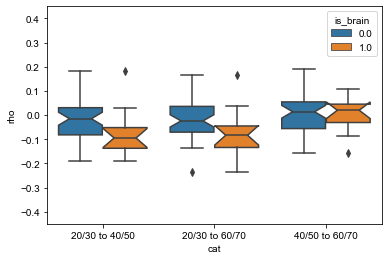

In [58]:
sns.boxplot(x='cat', y='rho', data=e[e['gender']=='females'], hue='is_brain', notch=True)
plt.ylim(-0.45, 0.45)

if save_images:
    export.export_image(
        '{}/notched_box_by_female_brain.pdf'.format(
            outfolder))

In [59]:
e

,region,cat,pval,rho,gender,is_brain
0,Adipose - Subcutaneous,20/30 to 40/50,1.302583e-10,-0.003812,males,0.0
1,Adipose - Subcutaneous,20/30 to 60/70,3.871957e-04,0.019523,males,0.0
2,Adipose - Subcutaneous,40/50 to 60/70,1.646914e-10,0.008341,males,0.0
3,Adipose - Visceral (Omentum),20/30 to 40/50,7.514724e-02,0.002517,males,0.0
4,Adipose - Visceral (Omentum),20/30 to 60/70,8.715350e-03,0.020501,males,0.0
...,...,...,...,...,...,...
49,Brain - Putamen (basal ganglia),20/30 to 60/70,4.282641e-17,-0.101305,females,1.0
50,Brain - Putamen (basal ganglia),40/50 to 60/70,2.488809e-26,0.057069,females,1.0
52,Brain - Substantia nigra,20/30 to 40/50,1.947550e-14,-0.098406,females,1.0
53,Brain - Substantia nigra,20/30 to 60/70,5.397138e-18,-0.065821,females,1.0


In [60]:
m = e[
    (e['gender']=='males') &
    (e['is_brain']==False)
]
m_rho = m.pivot(index='region', columns='cat', values='rho').reindex(
    columns=['20/30 to 40/50', '20/30 to 60/70']
)
m_pval = m.pivot(index='region', columns='cat', values='pval').reindex(
    columns=['20/30 to 40/50', '20/30 to 60/70']
)

In [61]:
if save_images:
    export.export_full_frame(
        '{}/table_imbalance_male.xlsx'.format(outfolder),
        m_rho)
    
    export.export_full_frame(
        '{}/table_pval_male.xlsx'.format(outfolder),
        m_pval)

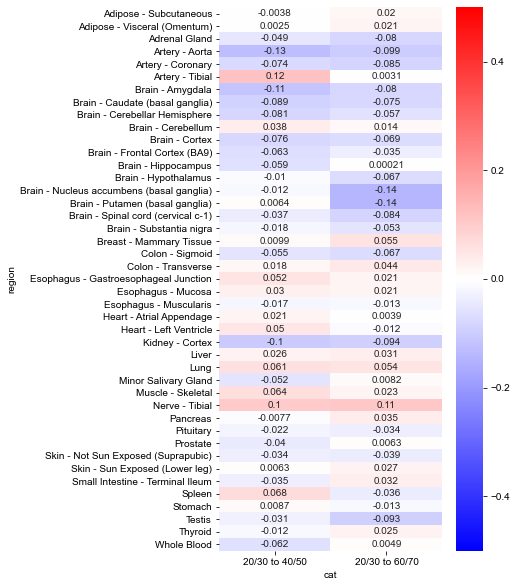

In [62]:
plt.figure(figsize=(5, 10))
sns.heatmap(m_rho, vmin=-0.5, vmax=0.5, cmap='bwr', annot=True)

if save_images:
    export.export_image(
        '{}/table_imbalance_male.pdf'.format(
            outfolder))

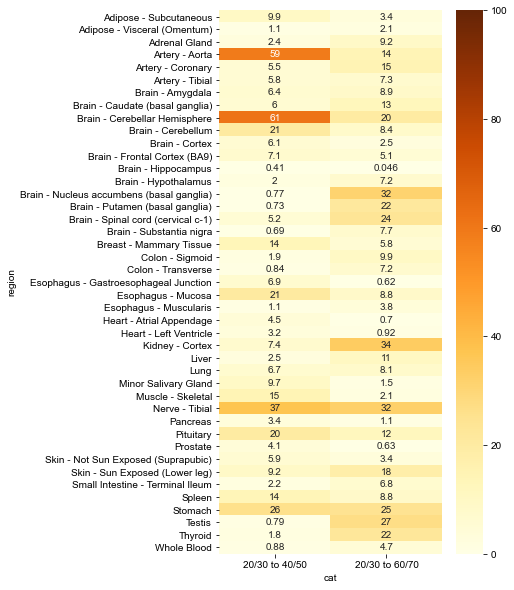

In [63]:
plt.figure(figsize=(5, 10))
sns.heatmap(m_pval.apply(lambda x: -np.log10(x)), annot=True, vmin=0, vmax=100, cmap='YlOrBr')


if save_images:
    export.export_image(
        '{}/table_pval_male.pdf'.format(
            outfolder))

In [64]:
m = e[
    (e['gender']=='females') & 
    (e['is_brain']==False)
]
m_rho = m.pivot(index='region', columns='cat', values='rho').reindex(
    columns=['20/30 to 40/50', '20/30 to 60/70']
)
m_pval = m.pivot(index='region', columns='cat', values='pval').reindex(
    columns=['20/30 to 40/50', '20/30 to 60/70']
)

In [65]:
if save_images:
    export.export_full_frame(
        '{}/table_imbalance_female.xlsx'.format(outfolder),
        m_rho)
    
    export.export_full_frame(
        '{}/table_pval_female.xlsx'.format(outfolder),
        m_pval)

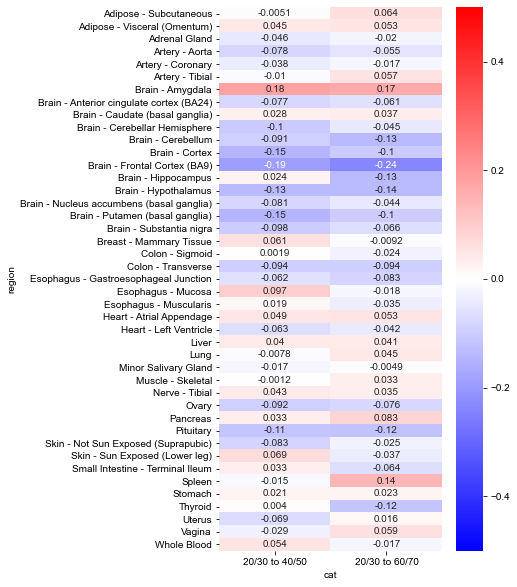

In [66]:
plt.figure(figsize=(5, 10))
sns.heatmap(m_rho, vmin=-0.5, vmax=0.5, cmap='bwr', annot=True)

if save_images:
    export.export_image(
        '{}/table_imbalance_female.pdf'.format(
            outfolder))

In [67]:
if save_images:
    export.export_image(
        '{}/table_pval_female.pdf'.format(
            outfolder))

<Figure size 432x288 with 0 Axes>

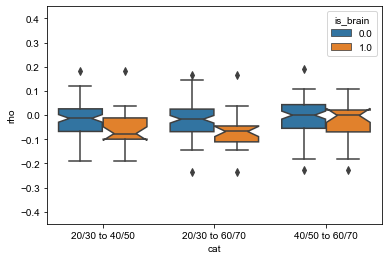

In [68]:
sns.boxplot(x='cat', y='rho', data=e, hue='is_brain', notch=True)
plt.ylim(-0.45, 0.45)


if save_images:
    export.export_image(
        '{}/notched_box_by_brain.pdf'.format(
            outfolder))

In [69]:
if save_images:
    export.export_full_frame(
        '{}/summary_stats.xlsx'.format(outfolder), e)

In [70]:
from scipy.stats import mannwhitneyu

In [71]:
def comp(t):
    a = t[t['cat']=='20/30 to 40/50']['rho']
    b = t[t['cat']=='20/30 to 60/70']['rho']
    
    _, p = mannwhitneyu(a, b, alternative='two-sided')
    print(p)
    return

In [72]:
comp(e[e['is_brain']==True])

0.7966032079051237


In [73]:
comp(e[(e['is_brain']==True) & (e['gender']=='males')])

0.40250382378200356


In [74]:
comp(e[(e['is_brain']==True) & (e['gender']=='females')])

0.7074539677020747


In [75]:
d.loc[:, 'is_brain'] = d.loc[:, 'region'].str.startswith('Brain_') == True

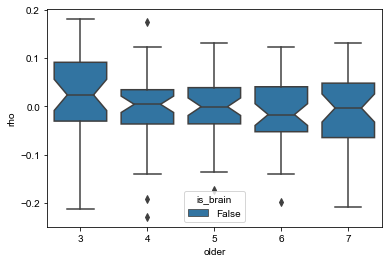

In [76]:
sns.boxplot(
    x='older',
    y='rho',
    data=d[(d['younger'].isin([2])) & (d['gender']=='males')],
    hue='is_brain',
    notch=True
)



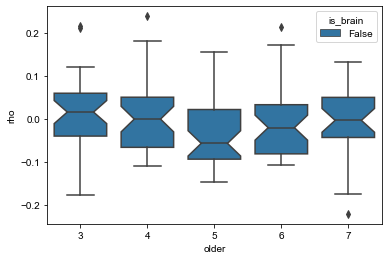

In [77]:
sns.boxplot(
    x='older',
    y='rho',
    data=d[(d['younger'].isin([2])) & (d['gender']=='females')],
    hue='is_brain',
    notch=True
)



In [78]:
def comp(t, s):
    a = t[(t['cat']==s) & (t['is_brain']==True)]['rho']
    b = t[(t['cat']==s) & (t['is_brain']==False)]['rho']
    
    _, p = mannwhitneyu(a, b, alternative='two-sided')
    print(p)
    return

In [79]:
comp(e, '20/30 to 40/50')

0.010733026764300359


In [80]:
comp(e, '20/30 to 60/70')

0.0020726378772829798
